In [1]:
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/test/Elmar_Brok_30.jpg  
  inflating: data/test/Elmar_Brok_31.jpg  
  inflating: data/test/Elsa_Zylberstein_00.jpg  
  inflating: data/test/Elsa_Zylberstein_01.jpg  
  inflating: data/test/Elsa_Zylberstein_10.jpg  
  inflating: data/test/Elsa_Zylberstein_11.jpg  
  inflating: data/test/Elsa_Zylberstein_40.jpg  
  inflating: data/test/Elsa_Zylberstein_41.jpg  
  inflating: data/test/Elton_John_10.jpg  
  inflating: data/test/Elton_John_11.jpg  
  inflating: data/test/Elton_John_20.jpg  
  inflating: data/test/Elton_John_21.jpg  
  inflating: data/test/Elton_John_30.jpg  
  inflating: data/test/Elton_John_31.jpg  
  inflating: data/test/Elton_John_40.jpg  
  inflating: data/test/Elton_John_41.jpg  
  inflating: data/test/Emile_Lahoud_00.jpg  
  inflating: data/test/Emile_Lahoud_01.jpg  
  inflating: data/test/Emile_Lahoud_30.jpg  
  inflating: data/test/Emile_Lahoud_31.jpg  
  inflating: data/test/Emile_Lahoud_40.jpg  


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg
import cv2
%matplotlib inline

In [0]:
class FacialKeyPointsDataset(tf.keras.utils.Sequence):
    def __init__(self, csv_file, root_dir, output_size, batch_size, shuffle=False, normalization="vector"):
        """
        this fun that have relevent information about the data with arguments 
         -> csv_file file that conaining names of images and oints value, ->root_dir: directory that have images, 
         -> output_size the size of output image after preprocessing, and batch_size batch size, 
         or decide whether we want to shuffle our data at generation.
        initializing a generator for a spacific data directory
        """
        self.keypts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.output_size = output_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        """
        we would use normalization for our data; normalization is a technipue of organizing the data into mulitpule related tables, 
        to minimize. data redundency you can search for Basic Concept of Database Normalization to know more.
        taking this idea from "mahmoudysuof facial_keypoint_detection repo"
        """
        # the mean and std vectors are going to be used in the normalized methods
        # we also need them to be public properties of the object since we will need them
        # after predicting the keypoints to undo normalization
        
        # I am trying different normalization methods for the keypoints
        # spoiler alert: the vector normalization works best as expected because I am a genious
        if normalization == 'scaler':
            self.mean = self.keypts_frame.iloc[:, 1:].values.mean()
            self.std = self.keypts_frame.iloc[:, 1:].values.std()
        elif normalization == 'vector':
            self.mean = self.keypts_frame.iloc[:, 1:].values.mean(axis=0).reshape(-1, 1)
            self.std = self.keypts_frame.iloc[:, 1:].values.std(axis=0).reshape(-1, 1)
        elif normalization == 'none':
            self.mean = 0
            self.std = 1
        else:
            raise ValueError("normalization must be one of 'scaler', 'vector', or 'none'")
        
        self.on_epoch_end()


    def on_epoch_end(self):
        """ 
        the method on_epoch_end is triggered once at the very beginning as well as at the end of each epoch. 
        If the shuffle parameter is set to True, we will get a new order of exploration at each pass 
        (or just keep a linear exploration scheme otherwise).
        """

        
        # all possible indecies in the dataframe
        self.indecies = np.arange(len(self.keypts_frame))
        if self.shuffle:
            np.random.shuffle(self.indecies)


    def __len__(self):
        """ 
        A common practice is to set this value to
        of samples devided by batch size giving the total number of bateches
      
        """
        return int(len(self.keypts_frame) / self.batch_size)

    def __getitem__(self, idx):
        """ This is where the magic hapenes, the model will call this function using the
        indexing operator 'generator[0]' or whatever.
        then and only then will the generator load the batch into memory and the garbage collector
        will remove it on the next iteration
        
        """
        # initialize the batch as empty arrays
        X = np.empty((self.batch_size, *self.output_size, 1))
        y = np.empty((self.batch_size, 136, 1))
        
        # get the indecies of the current batch only
        indecies = self.indecies[idx*self.batch_size:(idx+1)*self.batch_size]

        for index in range(len(indecies)):
            # get the image name
            image_name = os.path.join(self.root_dir,
                                    self.keypts_frame.iloc[indecies[index], 0])
            # load the image data
            image = mpimg.imread(image_name)
            
            # if image has an alpha color channel, get rid of it
            if(image.shape[2] == 4):
                image = image[:,:,0:3]
            
            # get the associated key points
            key_pts = self.keypts_frame.iloc[indecies[index], 1:].to_numpy()
            
            # process the image and the keypoints
            image, key_pts = self.preprocess_train(image, key_pts)
            image = image.reshape(*self.output_size, 1).astype(np.float32)
            key_pts = key_pts.astype(np.float32)
            
            # add the image data to the initialized arrays
            X[index,] = image
            y[index] = key_pts
        # return batch
        return X, y
    
    def preprocess_train(self, image, key_pts):
        image, key_pts = self.__rescale(image, key_pts)
        image, key_pts = self.__randomCrop(image, key_pts)
        image, key_pts = self.__normalize(image, key_pts)
        return image, key_pts
    
    def preprocess_test(self, image):
        key_pts = np.random.rand(136, 1)
        image, key_pts = self.__rescale(image, key_pts, train=False)
        image, key_pts = self.__normalize(image, key_pts)
        return image
        

    def __normalize(self, image, key_pts):
        """ Normailze image and key points
        Args:
            image: the image to be normalized
            key_pts: the associated key points
        Returns:
            image_copy: normalized image
            key_pts_copy: normalized key points numpy array of size (136, 1)
        """
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        key_pts_copy = (key_pts_copy - self.mean)/self.std
        return image_copy, key_pts_copy
    
    def __randomCrop(self, image, key_pts):
        key_pts = key_pts.reshape(-1, 2)
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return image, key_pts.reshape(-1, 1)
    
    def __rescale(self, image, key_pts, train=True):
        key_pts = key_pts.reshape(-1, 2)
        h, w = image.shape[:2]

        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        # to be cropped later
        if train:
            new_h = new_h + 4
            new_w = new_w + 4
        
        
        img = cv2.resize(image, (new_w, new_h))
        
        key_pts = key_pts * [new_w / w, new_h / h]

        return img, key_pts.reshape(-1, 1)

In [4]:
# now let's try it and debug it
datagenerator = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                         root_dir='data/training/',
                                         output_size=(194, 194),
                                         batch_size=30)

print(len(datagenerator))
X_batch, y_batch = datagenerator[len(datagenerator)-1]
print(X_batch.shape, y_batch.shape)

115
(30, 194, 194, 1) (30, 136, 1)


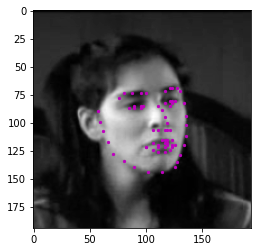

In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_batch[0].reshape(194, 194), cmap="gray")
keypts = y_batch[0] * datagenerator.std + datagenerator.mean
keypts = keypts.reshape(-1, 2)
plt.scatter(keypts[:, 0], keypts[:, 1], marker=".", s=20, color="m")